# Visualize Multiple VRP Solutions

**Usage**  
1. Set `nodes_filepath` and `solution_routes_filepaths` in the **Inputs** cell.  
2. Run all cells.  
3. The notebook will render one figure **per solution** (no seaborn). Each route uses a different color and the legend shows the `vehicle_name`. Distances are labeled along each edge (km).  
4. Titles include the solution file path so you can compare runs (GA / ACO / PSO) side by side.



[route-table] Per-route metrics:
             cluster     vehicle  route_index  num_stops  start_id  end_id  total_distance_km
solution_routes.json Truck-01-c6            1         22         0       0             80.072
solution_routes.json Truck-01-c4            1         12         0       0             21.001
solution_routes.json Truck-01-c3            1         14         0       0             29.859
solution_routes.json Truck-01-c0            1         10         0       0             21.624
solution_routes.json Truck-01-c5            1         14         0       0             19.169
solution_routes.json Truck-01-c1            1         12         0       0             32.769
solution_routes.json Truck-01-c2            1          6         0       0             24.662

[route-table] TOTAL distance across ALL routes: 229.156 km

[route-table] Total distance per cluster:
             cluster  cluster_total_km
solution_routes.json           229.156
[route-table] Saved CSV: route_me

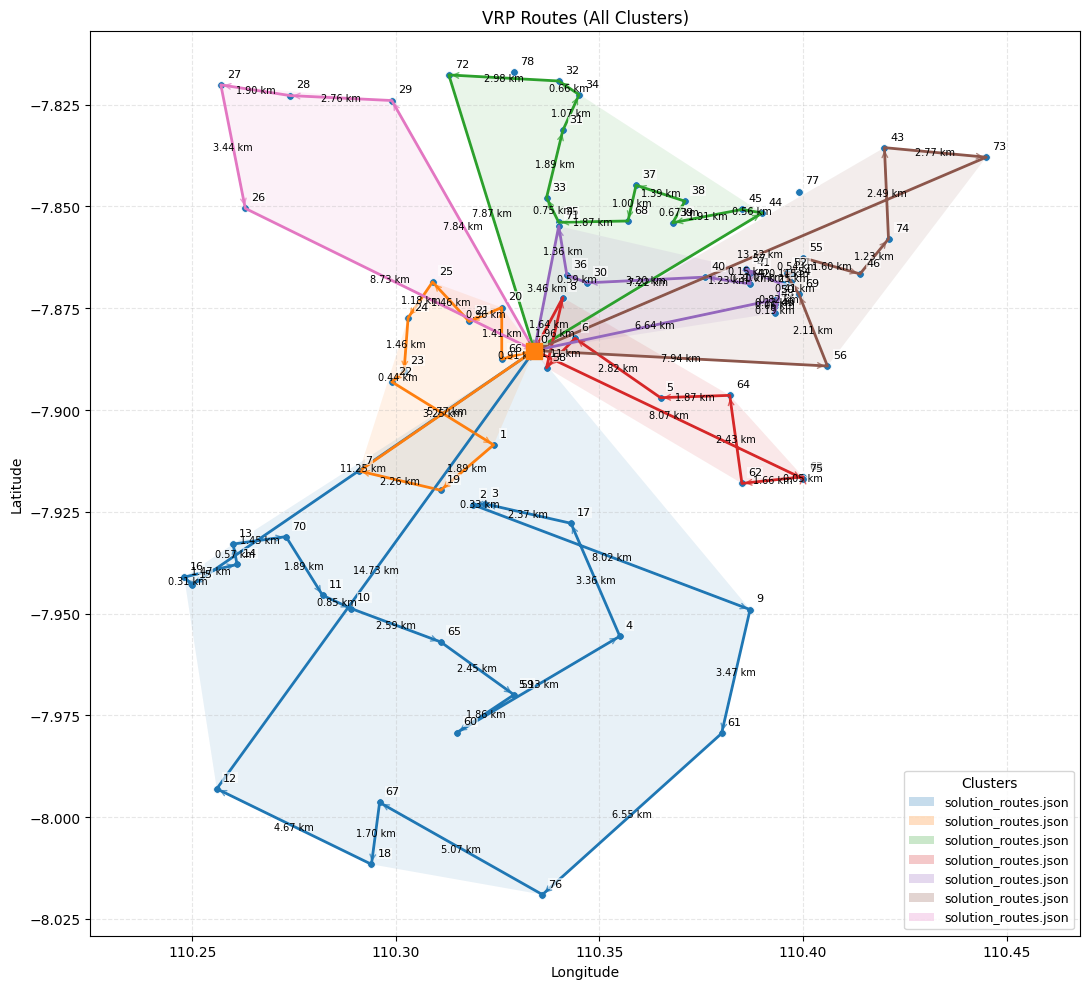

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x

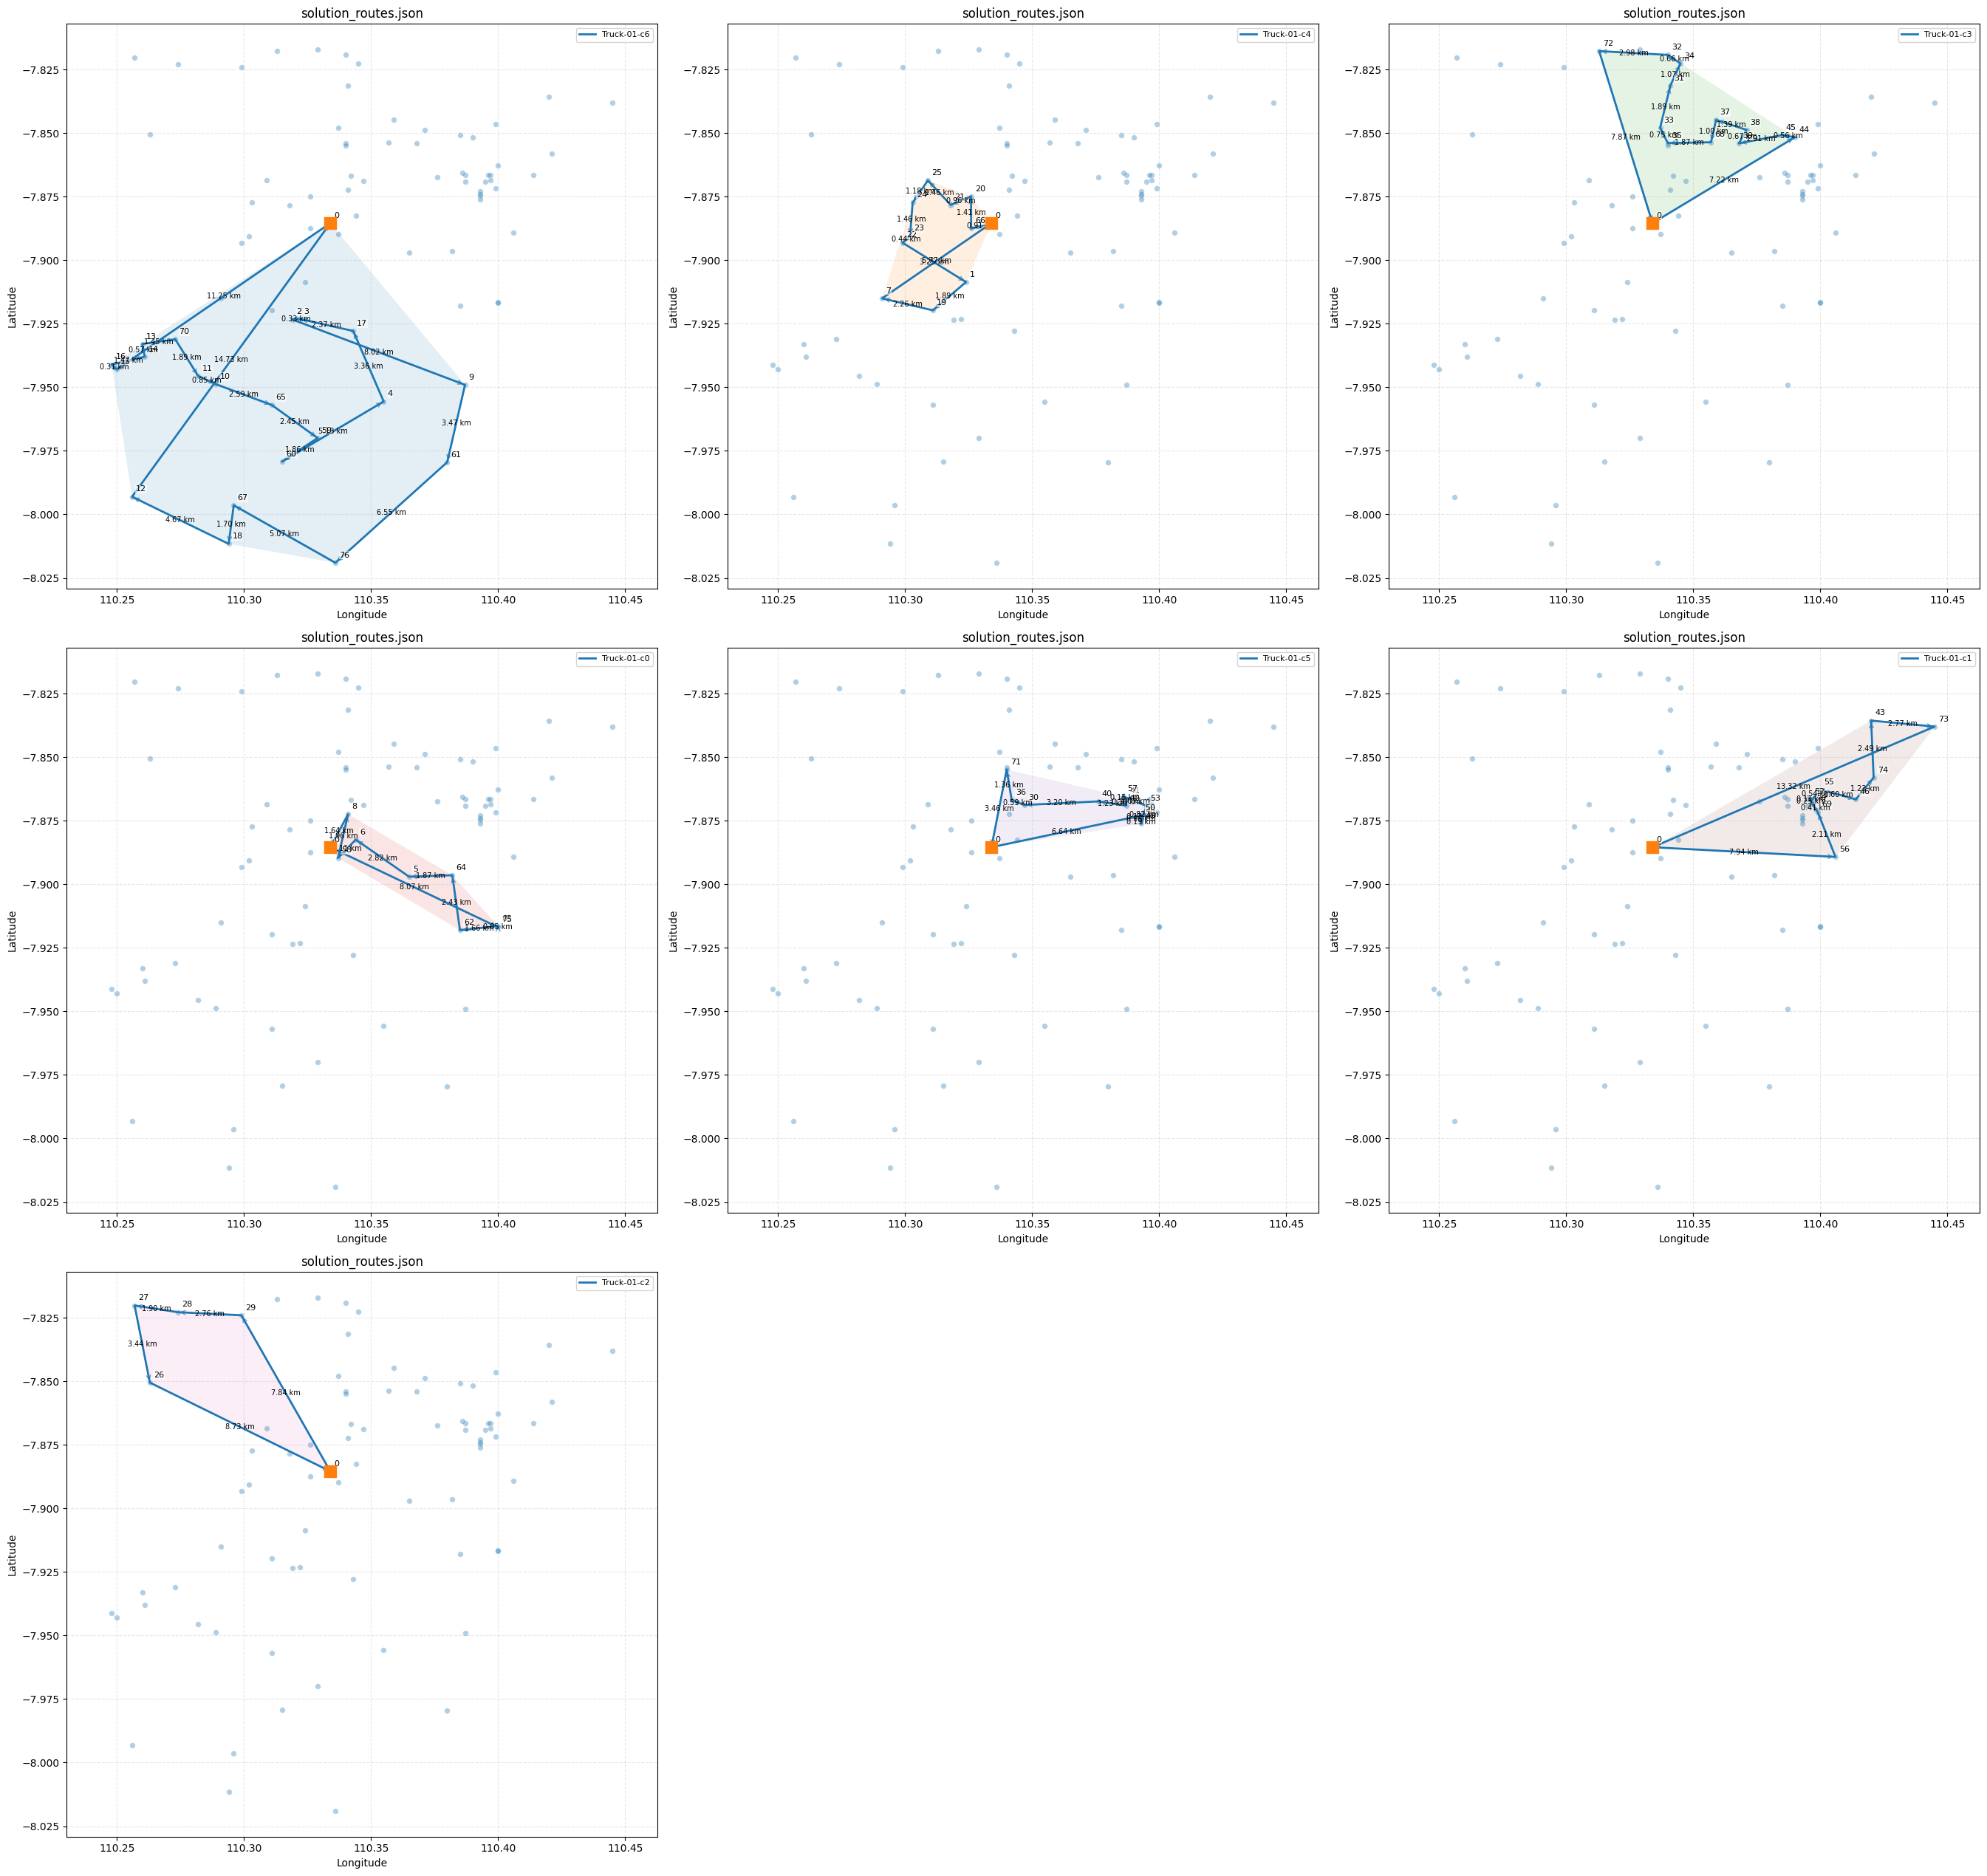

In [1]:
# viz/plot_routes_one_figure.py
# -*- coding: utf-8 -*-
"""
Single-figure + per-cluster subplots VRP route visualizer (ID-based only)
with per-route metrics table.

- Plots ALL provided (or auto-discovered) solution_routes.json files on ONE axes.
- Also produces a subplot grid: one panel per cluster (file).
- Optional: save PNG for the combined figure, the grid, and each cluster.
- Shades each cluster's convex hull, draws routes with arrows, optional per-edge km labels.
- Computes per-route totals (distance, #stops, start/end), prints and can save CSV.
- 100% node-ID based; no indexing assumptions.
"""

# === Inputs ===
# Option A: explicit list of solution files (comment out to rely on auto-discovery)
SOLUTION_FILES = [
    # "results/cluster_0/solution_routes.json",
    # "results/cluster_1/solution_routes.json",
]

# Option B: auto-discover all results/**/cluster_*/solution_routes.json
AUTO_DISCOVER_RESULTS_ROOT = "results/GIB_AZAM_124"

# Nodes CSV (must contain: id, lat, lon [, demand])
NODES_CSV = "Problems/GIB.csv"

# Visual toggles
USE_BASENAME_IN_LABEL = True     # labels use basename instead of full path
DRAW_ARROWS = True
ANNOTATE_EDGE_KM = True
DRAW_CLUSTER_HULL = True

# Save toggles/paths
SAVE_COMBINED_FIG = False
COMBINED_PNG = "routes_all_clusters.png"

MAKE_SUBPLOTS = True
SUBPLOT_MAX_COLS = 3
SAVE_SUBPLOT_GRID = False
SUBPLOT_GRID_PNG = "routes_clusters_grid.png"

SAVE_EACH_CLUSTER = False
EACH_CLUSTER_DIR = "routes_by_cluster_png"

# --- Route table output ---
MAKE_ROUTE_TABLE = True
SAVE_ROUTE_TABLE_CSV = True
ROUTE_TABLE_CSV = "route_metrics.csv"

# ---------------------------------------------------------------------

from __future__ import annotations

import json
import math
import os
import glob
from typing import Dict, List, Tuple, Iterable

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# ---- geo helpers ----
EARTH_R = 6_371_000  # meters

def haversine_km(lat1: float, lon1: float, lat2: float, lon2: float) -> float:
    p1, p2 = math.radians(lat1), math.radians(lat2)
    dphi = p2 - p1
    dlmb = math.radians(lon2 - lon1)
    a = math.sin(dphi/2)**2 + math.cos(p1)*math.cos(p2)*math.sin(dlmb/2)**2
    return (2 * EARTH_R * math.atan2(math.sqrt(a), math.sqrt(1 - a))) / 1000.0

def path_distance_km(stops: List[int], coords: Dict[int, Tuple[float, float]]) -> float:
    """Sum great-circle distance along consecutive stop pairs."""
    if not stops or len(stops) < 2:
        return 0.0
    dist = 0.0
    for a, b in zip(stops[:-1], stops[1:]):
        if a not in coords or b not in coords:
            continue
        (lat1, lon1) = coords[a]
        (lat2, lon2) = coords[b]
        dist += haversine_km(lat1, lon1, lat2, lon2)
    return float(dist)

# ---- data I/O ----
def load_nodes(nodes_csv: str) -> Tuple[pd.DataFrame, Dict[int, Tuple[float, float]]]:
    df = pd.read_csv(nodes_csv)
    need = {"id", "lat", "lon"}
    if not need.issubset(df.columns):
        raise ValueError("nodes CSV must have columns: id, lat, lon[, demand]")
    df = df.sort_values("id").reset_index(drop=True)
    coords = {int(r.id): (float(r.lat), float(r.lon)) for r in df.itertuples(index=False)}
    return df, coords

def load_solution(path: str) -> Dict:
    with open(path, "r", encoding="utf-8") as f:
        data = json.load(f)
    if "routes" not in data:
        raise ValueError(f"{path} must contain top-level 'routes'.")
    return data

def discover_cluster_solutions(root: str) -> List[str]:
    patterns = [
        os.path.join(root, "cluster_*", "solution_routes.json"),
        os.path.join(root, "**", "cluster_*", "solution_routes.json"),
    ]
    found = []
    for pat in patterns:
        found.extend(glob.glob(pat, recursive=True))
    # dedup + keep order
    seen, uniq = set(), []
    for p in found:
        q = os.path.normpath(p)
        if q not in seen and os.path.isfile(q):
            seen.add(q); uniq.append(q)
    return uniq

def short_label(path: str) -> str:
    return os.path.basename(path) if USE_BASENAME_IN_LABEL else path

# ---- convex hull (monotone chain) ----
def convex_hull(points: List[Tuple[float, float]]) -> List[Tuple[float, float]]:  # (lon,lat)
    pts = sorted(set(points))
    if len(pts) <= 1:
        return pts[:]

    def cross(o, a, b):
        return (a[0]-o[0])*(b[1]-o[1]) - (a[1]-o[1])*(b[0]-o[0])

    lower = []
    for p in pts:
        while len(lower) >= 2 and cross(lower[-2], lower[-1], p) <= 0:
            lower.pop()
        lower.append(p)
    upper = []
    for p in reversed(pts):
        while len(upper) >= 2 and cross(upper[-2], upper[-1], p) <= 0:
            upper.pop()
        upper.append(p)
    return lower[:-1] + upper[:-1]

# ---- color helpers ----
def color_cycle():
    from itertools import cycle
    colors = plt.rcParams["axes.prop_cycle"].by_key().get("color", [])
    if not colors:
        colors = [
            "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728",
            "#9467bd", "#8c564b", "#e377c2", "#7f7f7f",
            "#bcbd22", "#17becf"
        ]
    return cycle(colors)

def assign_cluster_colors(paths: List[str]) -> Dict[str, str]:
    cyc = color_cycle()
    return {p: next(cyc) for p in paths}

# ---- shared helpers ----
def extract_ids_in_solution(sol: Dict) -> List[int]:
    ids = set()
    for r in sol.get("routes", []):
        for nid in r.get("stops_by_id", []):
            ids.add(int(nid))
    return sorted(ids)

def all_limits_from_nodes(nodes_df: pd.DataFrame) -> Tuple[float, float, float, float]:
    xs = nodes_df["lon"].astype(float).values
    ys = nodes_df["lat"].astype(float).values
    pad_x = (xs.max() - xs.min()) * 0.05 if xs.size else 0.0
    pad_y = (ys.max() - ys.min()) * 0.05 if ys.size else 0.0
    return xs.min()-pad_x, xs.max()+pad_x, ys.min()-pad_y, ys.max()+pad_y

# ---- route metrics table helpers ----
def summarize_solution_routes(
    solution_path: str,
    solution: Dict,
    coords: Dict[int, Tuple[float, float]],
) -> List[Dict[str, object]]:
    """
    Build per-route metrics for a single solution_routes.json.
    Returns a list of dict rows.
    """
    rows: List[Dict[str, object]] = []
    cluster_label = short_label(solution_path)

    for ridx, route in enumerate(solution.get("routes", []), start=1):
        stops = [int(x) for x in (route.get("stops_by_id") or [])]
        veh_name = route.get("vehicle_name") or f"veh-{route.get('vehicle_id', ridx)}"
        total_km = path_distance_km(stops, coords)
        rows.append({
            "cluster": cluster_label,
            "vehicle": veh_name,
            "route_index": ridx,
            "num_stops": len(stops),
            "start_id": (stops[0] if stops else None),
            "end_id": (stops[-1] if stops else None),
            "total_distance_km": round(total_km, 3),
            "stops_by_id": stops,  # keep raw for reference
        })
    return rows

def summarize_all_routes(
    solution_paths: List[str],
    coords: Dict[int, Tuple[float, float]],
) -> pd.DataFrame:
    """Load each solution and aggregate per-route metrics into one DataFrame."""
    all_rows: List[Dict[str, object]] = []
    for p in solution_paths:
        try:
            sol = load_solution(p)
            all_rows.extend(summarize_solution_routes(p, sol, coords))
        except Exception as e:
            print(f"[WARN] skip {p} in table summary: {e}")
    df = pd.DataFrame(all_rows)
    if not df.empty:
        df = df.sort_values(["cluster", "route_index"]).reset_index(drop=True)
    return df

# ---- drawing primitives ----
def draw_nodes(
    ax,
    nodes_df: pd.DataFrame,
    annotate_ids: Iterable[int] | None = None,
    fade: bool = False,
    label_opacity: float = 1.0,
    label_bg: bool = True,
):
    """Plot all nodes; annotate only 'annotate_ids' if provided."""
    point_alpha = 0.35 if fade else 1.0
    z = 2 if fade else 3

    ax.scatter(
        nodes_df["lon"], nodes_df["lat"],
        s=30, zorder=z, linewidths=0.5, edgecolors="white", alpha=point_alpha
    )

    if annotate_ids is None:
        ids_to_label = nodes_df["id"].astype(int).tolist()
    else:
        ids_to_label = list(annotate_ids)
    ids_set = set(ids_to_label)

    for _, r in nodes_df.iterrows():
        nid = int(r["id"])
        if nid in ids_set:
            ax.text(
                float(r["lon"]) + 0.0015,
                float(r["lat"]) + 0.0015,
                str(nid),
                fontsize=8, ha="left", va="bottom",
                zorder=6,
                alpha=label_opacity,
                bbox=dict(facecolor="white", edgecolor="none", alpha=0.6, pad=0.4) if label_bg else None,
            )

def draw_depot(ax, coords: Dict[int, Tuple[float, float]]):
    if 0 in coords:
        depot_lat, depot_lon = coords[0]
        ax.scatter([depot_lon], [depot_lat], s=120, marker="s", zorder=7)

def draw_cluster_hull(ax, ids: List[int], coords: Dict[int, Tuple[float, float]], color: str, alpha=0.10):
    if not DRAW_CLUSTER_HULL:
        return
    pts = [(coords[i][1], coords[i][0]) for i in ids if i in coords]  # (lon,lat)
    if len(pts) >= 3:
        hull = convex_hull(pts)
        xs = [p[0] for p in hull] + [hull[0][0]]
        ys = [p[1] for p in hull] + [hull[0][1]]
        ax.fill(xs, ys, color=color, alpha=alpha, zorder=1, linewidth=0)

def draw_routes(ax, sol: Dict, coords: Dict[int, Tuple[float, float]], color: str, per_vehicle_colors: bool=False):
    cgen = None
    if per_vehicle_colors:
        cgen = color_cycle()
    for route in sol.get("routes", []):
        stops = route.get("stops_by_id") or []
        if len(stops) < 2:
            continue
        line_lon, line_lat = [], []
        for nid in stops:
            nid = int(nid)
            if nid not in coords:
                raise KeyError(f"Unknown node id in route: {nid}")
            lat, lon = coords[nid]
            line_lon.append(lon)
            line_lat.append(lat)

        col = next(cgen) if per_vehicle_colors else color
        ax.plot(line_lon, line_lat, linewidth=2.0, color=col, zorder=4, label=route.get("vehicle_name"))

        if DRAW_ARROWS:
            for i in range(len(stops) - 1):
                sx, sy = line_lon[i], line_lat[i]
                ex, ey = line_lon[i + 1], line_lat[i + 1]
                mx, my = (sx + ex) / 2.0, (sy + ey) / 2.0
                ax.annotate("", xy=(ex, ey), xytext=(mx, my),
                            arrowprops=dict(arrowstyle="->", lw=1, alpha=0.7, color=col),
                            zorder=5)

        if ANNOTATE_EDGE_KM:
            for a, b in zip(stops[:-1], stops[1:]):
                (lat1, lon1) = coords[int(a)]
                (lat2, lon2) = coords[int(b)]
                d_km = haversine_km(lat1, lon1, lat2, lon2)
                mx = (lon1 + lon2) / 2.0
                my = (lat1 + lat2) / 2.0
                ax.text(mx, my, f"{d_km:.2f} km", fontsize=7, ha="center", va="center",
                        color="black", zorder=6)

# ---- figures ----
def plot_all_on_one_figure(
    nodes_df: pd.DataFrame,
    coords: Dict[int, Tuple[float, float]],
    solution_paths: List[str],
    cluster_colors: Dict[str, str],
) -> None:
    loaded: List[Tuple[str, Dict]] = []
    for p in solution_paths:
        try:
            loaded.append((p, load_solution(p)))
        except Exception as e:
            print(f"[WARN] skip {p}: {e}")

    if not loaded:
        print("No valid solution_routes.json files to plot.")
        return

    fig, ax = plt.subplots(figsize=(11, 10))
    ax.set_title("VRP Routes (All Clusters)")

    draw_nodes(ax, nodes_df, annotate_ids=None, fade=False)
    draw_depot(ax, coords)

    cluster_handles: List[Patch] = []
    for path, sol in loaded:
        col = cluster_colors[path]
        label = short_label(path)
        ids = extract_ids_in_solution(sol)
        draw_cluster_hull(ax, ids, coords, col, alpha=0.10)
        cluster_handles.append(Patch(facecolor=col, edgecolor="none", alpha=0.25, label=label))
        draw_routes(ax, sol, coords, color=col, per_vehicle_colors=False)

    if cluster_handles:
        ax.legend(handles=cluster_handles, title="Clusters", loc="best", fontsize=9)

    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.grid(True, linestyle="--", alpha=0.3)
    ax.set_aspect("equal", adjustable="datalim")
    plt.tight_layout()

    if SAVE_COMBINED_FIG:
        fig.savefig(COMBINED_PNG, dpi=220, bbox_inches="tight")
        print(f"Saved: {COMBINED_PNG}")

    plt.show()

def plot_subplots_per_cluster(
    nodes_df: pd.DataFrame,
    coords: Dict[int, Tuple[float, float]],
    solution_paths: List[str],
    cluster_colors: Dict[str, str],
) -> None:
    loaded: List[Tuple[str, Dict]] = []
    for p in solution_paths:
        try:
            loaded.append((p, load_solution(p)))
        except Exception as e:
            print(f"[WARN] skip {p}: {e}")
    if not loaded:
        print("No valid solution_routes.json files to plot.")
        return

    xmin, xmax, ymin, ymax = all_limits_from_nodes(nodes_df)

    n = len(loaded)
    ncols = min(max(1, int(SUBPLOT_MAX_COLS)), n)
    nrows = (n + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(9 * ncols, 8.5 * nrows))

    # Normalize axes to 2D list
    if nrows == 1 and ncols == 1:
        axes = [[axes]]
    elif nrows == 1:
        axes = [axes]
    elif ncols == 1:
        axes = [[ax] for ax in axes]

    if SAVE_EACH_CLUSTER:
        os.makedirs(EACH_CLUSTER_DIR, exist_ok=True)

    for k, (path, sol) in enumerate(loaded):
        r, c = divmod(k, ncols)
        ax = axes[r][c]
        label = short_label(path)
        col = cluster_colors[path]

        ax.set_title(label)

        ids = extract_ids_in_solution(sol)

        # Background: faint all nodes, but annotate ONLY cluster nodes (clearer)
        draw_nodes(ax, nodes_df, annotate_ids=ids, fade=True, label_opacity=1.0, label_bg=True)
        draw_depot(ax, coords)

        draw_cluster_hull(ax, ids, coords, col, alpha=0.12)
        draw_routes(ax, sol, coords, color=col, per_vehicle_colors=True)

        ax.set_xlim(xmin, xmax)
        ax.set_ylim(ymin, ymax)
        ax.set_xlabel("Longitude")
        ax.set_ylabel("Latitude")
        ax.grid(True, linestyle="--", alpha=0.3)
        ax.set_aspect("equal", adjustable="datalim")

        handles, labels = ax.get_legend_handles_labels()
        if handles:
            ax.legend(loc="best", fontsize=8)

        if SAVE_EACH_CLUSTER:
            out_png = os.path.join(EACH_CLUSTER_DIR, f"{os.path.splitext(os.path.basename(path))[0]}.png")
            fig_i = ax.figure
            fig_i.canvas.draw()
            fig_i.savefig(out_png, dpi=220, bbox_inches="tight")
            print(f"Saved: {out_png}")

    # Hide any empty subplots
    for k in range(n, nrows * ncols):
        r, c = divmod(k, ncols)
        axes[r][c].axis("off")

    plt.tight_layout()

    if SAVE_SUBPLOT_GRID:
        fig.savefig(SUBPLOT_GRID_PNG, dpi=220, bbox_inches="tight")
        print(f"Saved: {SUBPLOT_GRID_PNG}")

    plt.show()

# ---- main ----
def main():
    nodes_df, coords = load_nodes(NODES_CSV)

    files = list(SOLUTION_FILES)
    if AUTO_DISCOVER_RESULTS_ROOT and os.path.isdir(AUTO_DISCOVER_RESULTS_ROOT):
        discovered = discover_cluster_solutions(AUTO_DISCOVER_RESULTS_ROOT)
        for p in discovered:
            if p not in files:
                files.append(p)

    if not files:
        print("No solution_routes.json files provided or discovered.")
        return

    # === Per-route table ===
       # === Per-route table ===
    if MAKE_ROUTE_TABLE:
        metrics_df = summarize_all_routes(files, coords)
        if metrics_df.empty:
            print("[route-table] No routes found.")
        else:
            view_cols = ["cluster", "vehicle", "route_index", "num_stops", "start_id", "end_id", "total_distance_km"]
            print("\n[route-table] Per-route metrics:")
            print(metrics_df[view_cols].to_string(index=False))

            # NEW: totals
            total_all_km = float(metrics_df["total_distance_km"].sum())
            print(f"\n[route-table] TOTAL distance across ALL routes: {total_all_km:.3f} km")

            # (Optional) per-cluster roll-up
            per_cluster = (
                metrics_df.groupby("cluster", as_index=False)["total_distance_km"].sum()
                .rename(columns={"total_distance_km": "cluster_total_km"})
            )
            if not per_cluster.empty:
                print("\n[route-table] Total distance per cluster:")
                print(per_cluster.to_string(index=False))

            if SAVE_ROUTE_TABLE_CSV:
                metrics_df.to_csv(ROUTE_TABLE_CSV, index=False, encoding="utf-8")
                print(f"[route-table] Saved CSV: {ROUTE_TABLE_CSV}")

    # Assign consistent colors across all figures
    cluster_colors = assign_cluster_colors(files)

    # Combined figure
    plot_all_on_one_figure(nodes_df, coords, files, cluster_colors)

    # Subplot grid (one panel per cluster)
    if MAKE_SUBPLOTS:
        plot_subplots_per_cluster(nodes_df, coords, files, cluster_colors)

if __name__ == "__main__":
    main()


In [39]:
import json
import math
import os
from typing import Dict, List, Tuple

import pandas as pd
import matplotlib.pyplot as plt

# --- Haversine distance in kilometers ---
EARTH_R = 6371008.8  # meters
def haversine_km(lat1: float, lon1: float, lat2: float, lon2: float) -> float:
    p1, p2 = math.radians(lat1), math.radians(lat2)
    dphi = p2 - p1
    dlmb = math.radians(lon2 - lon1)
    a = math.sin(dphi/2)**2 + math.cos(p1)*math.cos(p2)*math.sin(dlmb/2)**2
    return (2 * EARTH_R * math.atan2(math.sqrt(a), math.sqrt(1 - a))) / 1000.0

def load_nodes(nodes_csv: str):
    df = pd.read_csv(nodes_csv)
    if not set(["id","lat","lon"]).issubset(df.columns):
        raise ValueError("nodes CSV must have columns: id, lat, lon")
    df = df.sort_values("id").reset_index(drop=True)
    # ensure depot id==0 exists
    if int(df.loc[0,"id"]) != 0:
        raise ValueError("Depot (id==0) must be first row; reindex your CSV.")
    # id -> (lat, lon)
    coords = {int(row.id):(float(row.lat), float(row.lon)) for row in df.itertuples(index=False)}
    return df, coords

def load_solution(path: str) -> Dict:
    with open(path, "r", encoding="utf-8") as f:
        data = json.load(f)
    if "routes" not in data:
        raise ValueError(f"{path} must contain a top-level 'routes' list.")
    return data

def title_from_path(path: str, use_basename: bool) -> str:
    return os.path.basename(path) if use_basename else path


In [40]:
def plot_solution(nodes_df, coords, solution: Dict, title: str):
    fig, ax = plt.subplots(figsize=(9, 9))

    # Plot all nodes
    xs = nodes_df["lon"].astype(float).values
    ys = nodes_df["lat"].astype(float).values
    ax.scatter(xs, ys, s=30, zorder=3)
    for _, r in nodes_df.iterrows():
        ax.text(float(r["lon"]) + 0.0015, float(r["lat"]) + 0.0015, str(int(r["id"])),
                fontsize=8, ha="left", va="bottom", zorder=4)

    # Emphasize depot
    depot_lon = float(nodes_df.loc[0, "lon"])
    depot_lat = float(nodes_df.loc[0, "lat"])
    ax.scatter([depot_lon], [depot_lat], s=120, marker="s", zorder=5)

    # Draw routes
    for route in solution["routes"]:
        stops = route.get("stops_by_id")
        name = route.get("vehicle_name", f"veh-{route.get('vehicle_id','?')}")
        if not stops or len(stops) < 2:
            continue

        # Build polyline lon/lat
        line_lon = []
        line_lat = []
        for nid in stops:
            lat, lon = coords[int(nid)]
            line_lon.append(lon)
            line_lat.append(lat)

        # plot line
        ax.plot(line_lon, line_lat, linewidth=2, label=name, zorder=2)

        # Add arrows to show direction
        for i in range(len(stops) - 1):
            start_lon, start_lat = line_lon[i], line_lat[i]
            end_lon, end_lat = line_lon[i + 1], line_lat[i + 1]

            # Add arrow at the middle of the segment
            mid_lon = (start_lon + end_lon) / 2
            mid_lat = (start_lat + end_lat) / 2

            ax.annotate('', xy=(end_lon, end_lat), xytext=(mid_lon, mid_lat),
                        arrowprops=dict(arrowstyle='->', color='black',
                                        lw=1, alpha=0.7))

        # annotate distances on each edge midpoint
        for a, b in zip(stops[:-1], stops[1:]):
            (lat1, lon1) = coords[int(a)]
            (lat2, lon2) = coords[int(b)]
            d_km = haversine_km(lat1, lon1, lat2, lon2)
            mx = (lon1 + lon2) / 2.0
            my = (lat1 + lat2) / 2.0
            ax.text(mx, my, f"{d_km:.2f} km", fontsize=7,
                    ha="center", va="center", rotation=0, zorder=6)

    ax.set_title(title)
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.legend(loc="best", fontsize=9)
    ax.grid(True, linestyle="--", alpha=0.3)
    plt.tight_layout()
    plt.show()

In [41]:
# Load nodes once
nodes_df, coords = load_nodes(nodes_filepath)

# Plot each solution file as a separate figure
for path in solution_routes_filepaths:
    sol = load_solution(path)
    ttl = title_from_path(path, use_basename_in_title)
    plot_solution(nodes_df, coords, sol, ttl)


NameError: name 'nodes_filepath' is not defined